In [ ]:
x=1

In [33]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R
library(edgeR)
library(MAST)

In [5]:
macrophages = sc.read('../../pipeline/data/analysis/hlca_healthy_ipf_embed_balanced/macrophages.h5ad')
macrophages

AnnData object with n_obs × n_vars = 138736 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_le

In [6]:
ipf_macrophages = macrophages[macrophages.obs['lung_condition_coarse'] == 'IPF'].copy()
ipf_macrophages

AnnData object with n_obs × n_vars = 104045 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_le

In [7]:
threshold_idx = int(len(ipf_macrophages) * 0.9)
threshold_value = sorted(ipf_macrophages.obs['cell_attn'])[threshold_idx]
threshold_value

0.018071629106998444

In [8]:
ipf_macrophages.obs['group'] = 'all'
ipf_macrophages.obs.loc[ipf_macrophages.obs['cell_attn'] >= threshold_value, 'group'] = 'top'

In [9]:
ipf_macrophages.obs['group'].value_counts()

group
all    93640
top    10405
Name: count, dtype: int64

In [13]:
ipf_macrophages.obs['sample_group'] = ipf_macrophages.obs['sample'].astype('str') + '_' + ipf_macrophages.obs['group']
ipf_macrophages.obs['sample_group'] = ipf_macrophages.obs['sample_group'].astype('category')

In [16]:
ipf_macrophages

AnnData object with n_obs × n_vars = 104045 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_le

In [21]:
samples_to_exclude = []
for sample in np.unique(ipf_macrophages.obs[['sample_group']]):
    sample_len = len(ipf_macrophages[ipf_macrophages.obs['sample_group'] == sample])
    if sample_len < 10:
        samples_to_exclude.append(sample)

In [22]:
samples_to_exclude

['Cryobiopsy_01_top',
 'IPF1_Lin_all',
 'IPF1_Lin_top',
 'IPF2_Lin_top',
 'IPF3_Lin_top',
 'VUILD64_top',
 'VUILD65_top']

In [23]:
ipf_macrophages = ipf_macrophages[~ipf_macrophages.obs['sample_group'].isin(samples_to_exclude)].copy()
ipf_macrophages

AnnData object with n_obs × n_vars = 104008 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_le

In [29]:
hlca = sc.read('../../../snakemake/hlca/5fold/hlca_hyperparam/data/pp/hlca_hvg_pearson.h5ad')
hlca

AnnData object with n_obs × n_vars = 2149684 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_l

In [30]:
hlca.X.data

array([1., 5., 1., ..., 1., 2., 3.], dtype=float32)

In [31]:
ipf_macrophages.obsm['counts'] = hlca[ipf_macrophages.obs_names].X
ipf_macrophages

AnnData object with n_obs × n_vars = 104008 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_le

In [32]:
ipf_macrophages.X = ipf_macrophages.obsm['counts'].copy()
ipf_macrophages.X.data

array([ 3.,  4., 14., ...,  1.,  2.,  3.], dtype=float32)

In [34]:
len(np.unique(ipf_macrophages.obs['sample_group']))

126

In [39]:
adata_ = dc.get_pseudobulk(ipf_macrophages, 'sample', 'group', mode='sum', min_cells=-1, min_counts=-1)
adata_                            

AnnData object with n_obs × n_vars = 126 × 1999
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'assay', 'cause_of_death', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'lung_condition', 'mixed_ancestry', 'original_ann_level_5', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'transf_ann_level_3_label', 'lung_condition_coarse', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'sample_group', 'psbulk_n_cells', 'psbulk_counts'
    var: 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'


In [41]:
adata_.layers['counts'] = adata_.X.copy()

In [42]:
sc.pp.normalize_total(adata_, target_sum=1e4)
sc.pp.log1p(adata_)
sc.pp.pca(adata_)

In [43]:
adata_.obs["lib_size"] = np.sum(adata_.layers["counts"], axis=1)
adata_.obs["log_lib_size"] = np.log(adata_.obs["lib_size"])

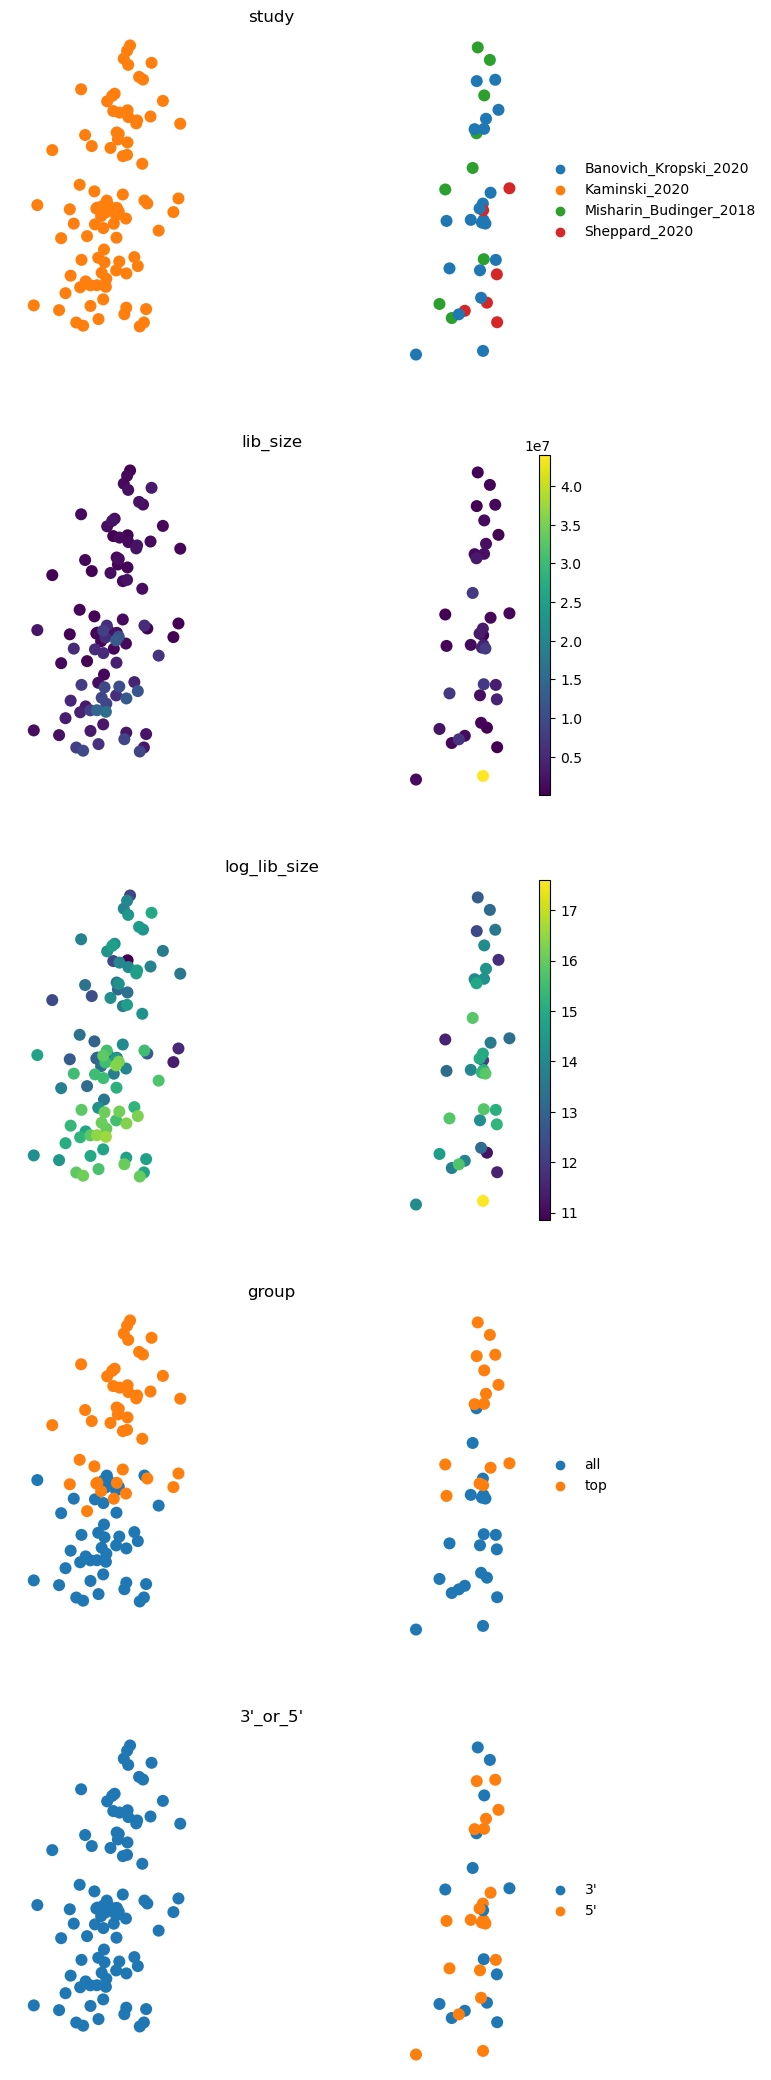

In [71]:
sc.pl.pca(adata_, color=['study', 'lib_size', 'log_lib_size', 'group', "3'_or_5'"], ncols=1, size=300, frameon=False)

In [92]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$group)
    # filter out genes with low counts
    print("Dimensions:")
    print(dim(y))
    print("")
    # keep <- filterByExpr(y)
    # y <- y[keep, , keep.lib.sizes=FALSE]
    # print("Dimensions after subsetting:")
    # print(dim(y))
    # print("")
    # normalize
    y <- calcNormFactors(y)
    # will add study covariate to the design matrix as there are still some batch effects
    group <- colData(adata_)$group
    replicate <- colData(adata_)$sample
    study <- colData(adata_)$study
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + group + replicate)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

In [76]:
adata_

AnnData object with n_obs × n_vars = 126 × 1999
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'assay', 'cause_of_death', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'lung_condition', 'mixed_ancestry', 'original_ann_level_5', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'transf_ann_level_3_label', 'lung_condition_coarse', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'sample_group', 'psbulk_n_cells', 'psbulk_counts', 'lib_size', 'log_lib_size'
    var: 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_inter

In [120]:
macro = sc.AnnData(adata_.X, obs=adata_.obs[['group', 'sample_group', 'study', 'sample']])
macro.var_names = adata_.var_names
macro.obs['sample'] = macro.obs['sample'].str.replace('-', '_')
macro

AnnData object with n_obs × n_vars = 126 × 1999
    obs: 'group', 'sample_group', 'study', 'sample'

In [121]:
macro = macro.copy()
macro

AnnData object with n_obs × n_vars = 126 × 1999
    obs: 'group', 'sample_group', 'study', 'sample'

In [122]:
%%time
%%R -i macro
outs <-fit_model(macro)

[1] "Dimensions:"
[1] 1999  126
[1] ""
CPU times: user 1min 44s, sys: 2min 43s, total: 4min 28s
Wall time: 1min 15s


In [123]:
%%R
fit <- outs$fit
y <- outs$y

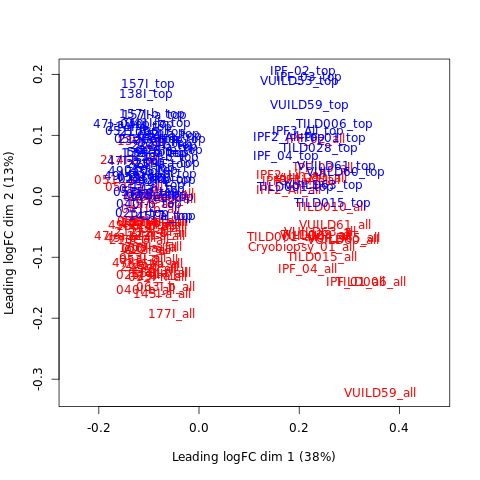

In [124]:
%%R
plotMDS(y, col=ifelse(y$samples$group == "all", "red", "blue"))

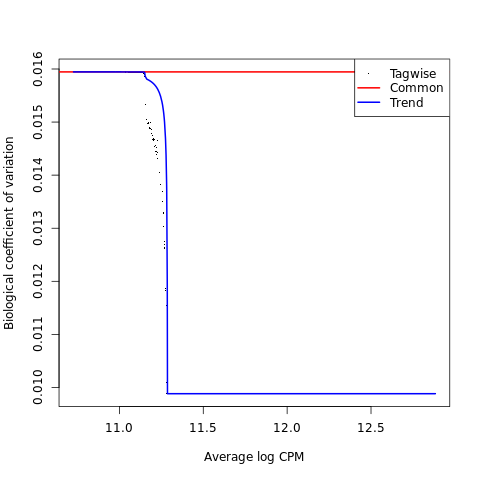

In [125]:
%%R
plotBCV(y)

In [126]:
%%R
colnames(y$design)

 [1] "groupall"               "grouptop"               "replicate021I"         
 [4] "replicate022I"          "replicate025I"          "replicate034I_a"       
 [7] "replicate040I"          "replicate040I_b"        "replicate041I_b"       
[10] "replicate051I"          "replicate051I_a"        "replicate053I"         
[13] "replicate053I_d"        "replicate053I_n"        "replicate063I_b"       
[16] "replicate123I"          "replicate135I_a"        "replicate135I_b"       
[19] "replicate138I"          "replicate138I_a"        "replicate145I_a"       
[22] "replicate157I"          "replicate157I_a"        "replicate157I_b"       
[25] "replicate158I_b"        "replicate166I_a"        "replicate174I_a"       
[28] "replicate177I"          "replicate179I"          "replicate209I_a"       
[31] "replicate210CO"         "replicate212I_a"        "replicate214I_a"       
[34] "replicate221I_a"        "replicate222I_a"        "replicate222I_b"       
[37] "replicate225I_a"        "replicate

In [127]:
%%R -o tt
myContrast <- makeContrasts("grouptop - groupall", levels = y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

In [128]:
tt.shape

(1999, 5)

In [129]:
tt[:5]

,logFC,logCPM,F,PValue,FDR
ENSG00000137673,1.920096,11.357908,336.655507,6.418333e-15,1.283025e-11
ENSG00000133048,1.701761,11.479351,352.146658,1.784167e-14,1.783275e-11
ENSG00000100985,1.342788,11.441837,240.892354,1.578954e-09,1.052110e-06
ENSG00000137801,-1.387214,11.371351,306.808163,2.880501e-09,1.439530e-06
ENSG00000170323,-0.846064,11.890371,113.308970,2.393674e-07,8.848218e-05


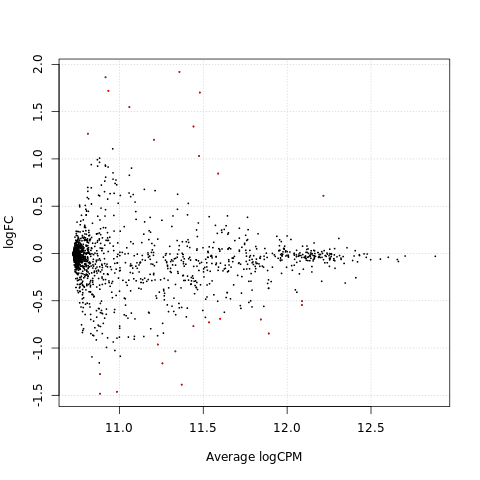

In [130]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.05)])

In [133]:
tt_sign = tt[tt['FDR'] < 0.05]
tt_sign

,logFC,logCPM,F,PValue,FDR
ENSG00000137673,1.920096,11.357908,336.655507,6.418333e-15,1.283025e-11
ENSG00000133048,1.701761,11.479351,352.146658,1.784167e-14,1.783275e-11
ENSG00000100985,1.342788,11.441837,240.892354,1.578954e-09,1.052110e-06
ENSG00000137801,-1.387214,11.371351,306.808163,2.880501e-09,1.439530e-06
ENSG00000170323,-0.846064,11.890371,113.308970,2.393674e-07,8.848218e-05
ENSG00000143320,1.862993,10.917349,717.026249,2.655793e-07,8.848218e-05
ENSG00000100234,1.548305,11.059512,407.968318,7.487876e-07,2.138323e-04
ENSG00000102962,1.720420,10.934277,361.055398,1.202373e-06,3.004429e-04
ENSG00000143387,1.030722,11.474828,200.081737,1.357827e-06,3.015885e-04
ENSG00000118785,0.610136,12.216398,198.529980,5.418703e-06,9.106701e-04


In [142]:
up_genes = list(tt_sign[tt_sign['logFC'] > 0].index)
up_genes

['ENSG00000137673',
 'ENSG00000133048',
 'ENSG00000100985',
 'ENSG00000143320',
 'ENSG00000100234',
 'ENSG00000102962',
 'ENSG00000143387',
 'ENSG00000118785',
 'ENSG00000007264',
 'ENSG00000133063',
 'ENSG00000069482']

In [143]:
macrophages_genes = {
    'SPP1': 'ENSG00000118785',
    'LIPA': 'ENSG00000107798',
    'LPL': 'ENSG00000175445',
    'FDX1': 'ENSG00000137714',
    'SPARC': 'ENSG00000113140',
    'MATK': 'ENSG00000007264',
    'GPC4': 'ENSG00000076716',
    'PALLD': 'ENSG00000129116',
    'MMP7': 'ENSG00000137673',
    'MMP9': 'ENSG00000100985',
    'CHIT1': 'ENSG00000133063',
    'CSTK': 'ENSG00000143387',
    'CHI3L1': 'ENSG00000133048',
    'CSF1': 'ENSG00000184371',
    'FCMR': 'ENSG00000162894',
    'TIMP3': 'ENSG00000100234',
    'COL22A1': 'ENSG00000169436',
    'SIGLEC15': 'ENSG00000197046',
    'CCL2': 'ENSG00000108691',
}

In [144]:
len(up_genes)

11

In [145]:
len(set(up_genes).intersection(set(macrophages_genes.values())))

8

In [146]:
set(up_genes) - set(macrophages_genes.values())

{'ENSG00000069482', 'ENSG00000102962', 'ENSG00000143320'}

In [147]:
missig_up_genes = {
    'ENSG00000069482': 'GAL', 
    # https://erj.ersjournals.com/content/erj/early/2018/08/09/13993003.00564-2018.full.pdf,
    # flavonoid compound that attenuates inflammatory damage and prevents EMT (ath with epithelial cells) in BLM-induced PF mice
    # <- macrophages are not eputhelial though
    # https://www.mdpi.com/1420-3049/27/5/1481
    # not sure
    'ENSG00000102962': 'CCL22',
    # https://pubmed.ncbi.nlm.nih.gov/19715610/ also not sure
    'ENSG00000143320': 'CRABP2',
    # yes in other cell types https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9141193/
}

In [148]:
down_genes = list(tt_sign[tt_sign['logFC'] < 0].index)
down_genes

['ENSG00000137801',
 'ENSG00000170323',
 'ENSG00000149131',
 'ENSG00000145287',
 'ENSG00000122641',
 'ENSG00000159189',
 'ENSG00000124491',
 'ENSG00000173372',
 'ENSG00000163736',
 'ENSG00000004799',
 'ENSG00000104918',
 'ENSG00000110077',
 'ENSG00000169245',
 'ENSG00000173369']

In [149]:
len(set(down_genes).intersection(set(macrophages_genes.values())))

0

In [150]:
ipf_macrophages

AnnData object with n_obs × n_vars = 104008 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_le

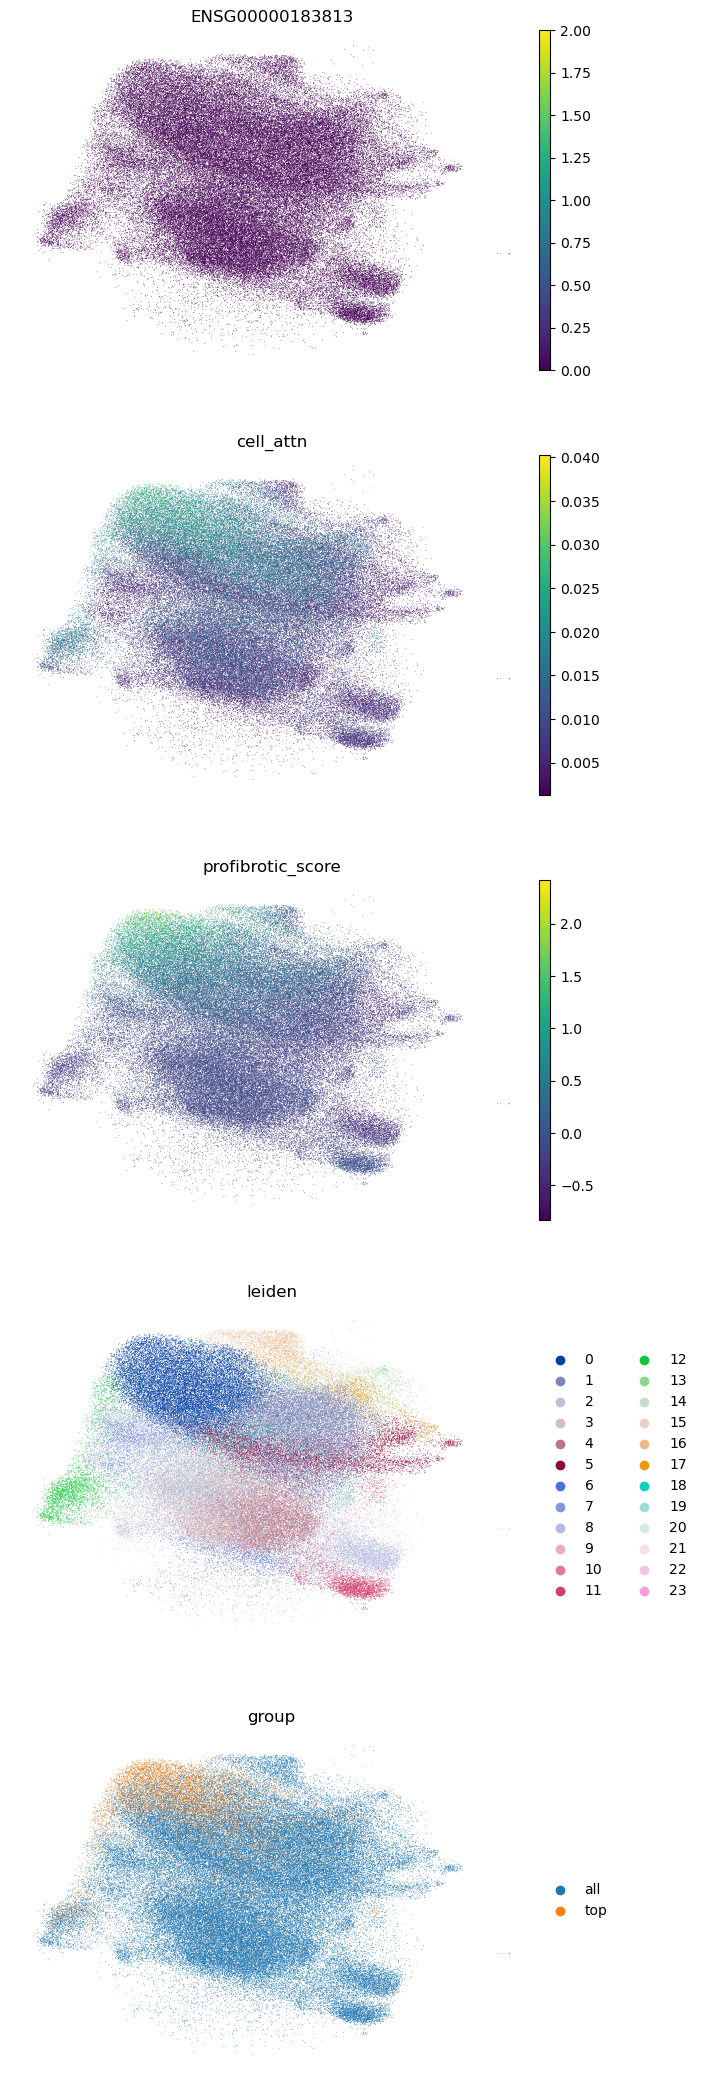

In [155]:
# CCR4 = ENSG00000183813
sc.pl.umap(ipf_macrophages, color=['ENSG00000183813', 'cell_attn', 'profibrotic_score', 'leiden', 'group'], ncols=1, frameon=False,)

In [1]:
import matplotlib_venn

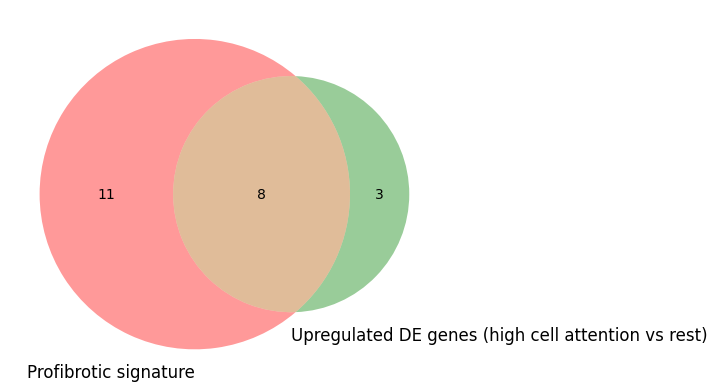

In [8]:
matplotlib_venn.venn2(subsets = (11, 3, 8), set_labels = ('Profibrotic signature', 'Upregulated DE genes (high cell attention vs rest)'))

# cluster 12 vs rest of high attention cells

In [158]:
ipf_macrophages[ipf_macrophages.obs['group'] == 'top']

View of AnnData object with n_obs × n_vars = 10375 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf

In [159]:
ipf_macrophages[ipf_macrophages.obs['leiden'] == '12']

View of AnnData object with n_obs × n_vars = 3553 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_